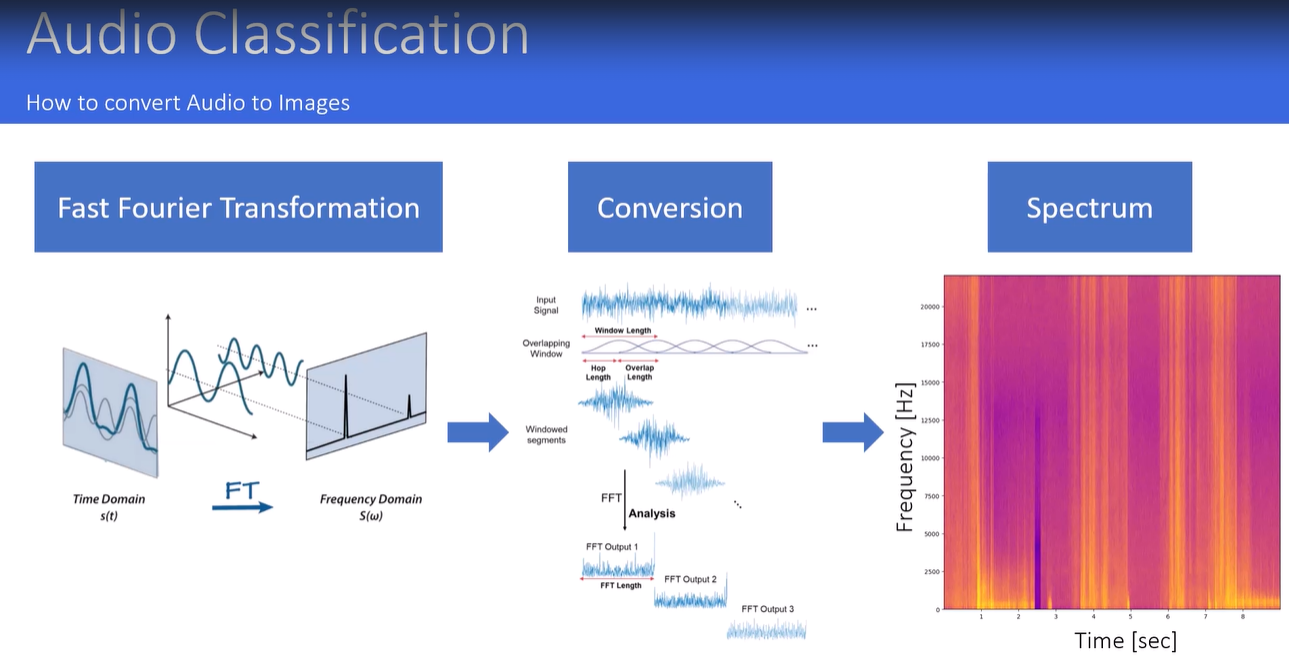

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/ml/audio/HeartbeatSounds.zip" -d "/content/HeartbeatSounds"

In [ ]:
import matplotlib.pyplot as plt
import torch

#%%
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

# source: adapted from https://pytorch.org/audio/stable/tutorials/audio_io_tutorial.html
def plot_specgram(waveform, sample_rate, file_path = 'test2.png'):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    
    fig, axes = plt.subplots( num_channels, 1)
    fig.set_size_inches(10, 10)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    plt.gca().set_axis_off()
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    # plt.show(block=False)
    plt.savefig(file_path, bbox_inches='tight', pad_inches = 0)
    

#Data - convert .wav files to spectrum images

In [ ]:
# Data prep - create train test folders with spectrum images
#%% package import
import torchaudio
import os
import random
# %%
wav_path = '/content/HeartbeatSounds/set_a'
wav_filenames = os.listdir(wav_path)
random.shuffle(wav_filenames)

# %%
ALLOWED_CLASSES = ['normal', 'murmur', 'extrahls', 'artifact']
for f in wav_filenames:
    class_type = f.split('_')[0]
    f_index = wav_filenames.index(f)
    # if file position is 0-139 then train folder, else test
    target_path = '/content/HeartbeatSounds/train' if f_index < 140 else '/content/HeartbeatSounds/test'
    class_path = f"{target_path}/{class_type}"
    file_path = f"{wav_path}/{f}"
    f_basename = os.path.basename(f)
    f_basename_wo_ext = os.path.splitext(f_basename)[0]
    target_file_path = f"{class_path}/{f_basename_wo_ext}.png"
    if (class_type in ALLOWED_CLASSES):
        # create folder if necessary
        if not os.path.exists(class_path):
            os.makedirs(class_path)
        # extract class type from file, e.g. 
        data_waveform, sr = torchaudio.load(file_path)
        # create spectrogram and save it
        
        plot_specgram(waveform=data_waveform, sample_rate=sr, file_path=target_file_path)
        
#%%

#Model and train

In [ ]:
#%% packages
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter
# %% transform and load data
transform = transforms.Compose(
    [transforms.Resize((100,100)),
      transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))])

batch_size = 4
trainset = torchvision.datasets.ImageFolder(root='/content/HeartbeatSounds/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.ImageFolder(root='/content/HeartbeatSounds/test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)



In [ ]:
# %%
CLASSES = ['artifact', 'extrahls', 'murmur', 'normal']
NUM_CLASSES = len(CLASSES)
class ImageMulticlassClassificationNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=6, kernel_size= 3, padding=1),nn.BatchNorm2d(6),nn.ReLU())
        self.pool = nn.MaxPool2d(2, 2)  
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=6, out_channels= 16, kernel_size=3, padding=1),nn.BatchNorm2d(16),nn.ReLU()) 
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(nn.Dropout(0.25),nn.Linear(100*100, 128),nn.ReLU()) # out: (BS, 128)
        self.fc2 = nn.Sequential(nn.Linear(128, 64),nn.ReLU())
        self.fc3 = nn.Sequential(nn.Linear(64, NUM_CLASSES))
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax()


    def forward(self, x):
        x = self.conv1(x) # out: (BS, 6, 100, 100)
        #x = self.relu(x)
        x = self.pool(x) # out: (BS, 6, 50, 50)
        x = self.conv2(x) # out: (BS, 16, 50, 50)
        #x = self.relu(x)
        x = self.pool(x) # out: (BS, 16, 25, 25)
        x = self.flatten(x)  # out: (BS, 10000)
        x = self.fc1(x)  # out: (BS, 128)
        #x = self.relu(x)
        x = self.fc2(x)  # out: (BS, 64)
        #x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

"""class VGG16(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out"""

input = torch.rand(1, 1, 100, 100) # BS, C, H, W
model = ImageMulticlassClassificationNet()      
# model(input).shape

# %% 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


In [ ]:
# %% TRAINING
losses_epoch_mean = []
NUM_EPOCHS = 100
#NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    losses_epoch = []
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        print(inputs.shape)
        optimizer.zero_grad()
        outputs = model(inputs)

        
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        losses_epoch.append(loss.item())
    losses_epoch_mean.append(np.mean(losses_epoch))
    print(f'Epoch {epoch}/{NUM_EPOCHS}, Loss: {np.mean(losses_epoch):.4f}')

#%% PLOT LOSSES
sns.lineplot(x=list(range(len(losses_epoch_mean))), y=losses_epoch_mean)



<ipython-input-48-a3403c7ea252>:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


Accuracy: 76.67 %


<AxesSubplot:>

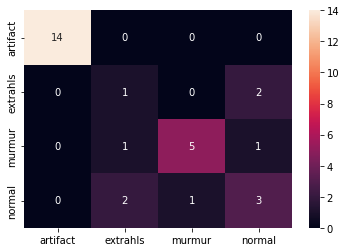

In [ ]:
# %% TESTING
y_test = []
y_test_hat = []
for i, data in enumerate(testloader, 0):
    inputs, y_test_temp = data
    with torch.no_grad():
        y_test_hat_temp = model(inputs).round()
    
    y_test.extend(y_test_temp.numpy())
    y_test_hat.extend(y_test_hat_temp.numpy())

# %% Baseline Classifier
Counter(y_test)
# most dominant class: 12 obs
# length y_test = 24
# 12 / 24 = 50 %


#%% Accuracy
acc = accuracy_score(y_test, np.argmax(y_test_hat, axis=1))
print(f'Accuracy: {acc*100:.2f} %')
# %% confusion matrix
cm = confusion_matrix(y_test, np.argmax(y_test_hat, axis=1))
sns.heatmap(cm, annot=True, xticklabels=CLASSES, yticklabels=CLASSES)
# %%